<a href="https://colab.research.google.com/github/serivan/mldmlab/blob/master/Kaggle/KAGGLE/how_to_submit_prediction_to_kaggle_in_python_with_sklearn_and_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here you will learn to submit your  keras model

to a machine learning competition in Python.  It's fun, and it will give you a way to see your progress as your skills keep improving.*

# Introduction
Machine learning competitions are a great way to improve your skills and measure your progress as a data scientist. If you are using data from a competition on Kaggle, you can easily submit it from your notebook.  Here's how you do it.

# Example
We're doing very minimal data set up here so we can focus on how to submit modeling results to competitions. Other tutorials will teach you how build great models. So the model in this example will be fairly simple. We'll start with the code to read data, select predictors, and fit a model.

## Define Constants

In [1]:
DATA_PATH = "https://raw.githubusercontent.com/serivan/mldmlab/master/Kaggle/KAGGLE/"
OUTPUT_PATH = "kaggle_submissions/"
RANDOM_STATE = 3993

DROPCOLUMS = ["Id", "target"]

DEFAULT_DESCRIPTION = "NN Submission: "

In [2]:
EPOCHS = 20
TRAIN_SIZE = 0.8
VAL_SIZE = 0.2
BATCH_SIZE = 32

## Imports

In [3]:
import os

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [5]:
### SPECIAL TENSORFLOW MEMORY MANAGEMENT ###
### REMOVE THIS CELL IN PRODUCTION ###
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [6]:
# if not 'sklearn' in sys.modules.keys():
#    pip.main(['install', 'sklearn'])
# if not 'kaggle' in sys.modules.keys():
#    pip.main(['install', 'kaggle'])
# import sys
# import pip

import random

print("Random number with seed 2021")
random.seed(2021)

Random number with seed 2021


In [65]:
!pip install scikeras

## Imports for Kaggle
See https://www.kaggle.com/docs/api

In [7]:
# from google.colab import drive

# drive.mount("/content/gdrive")

In [8]:
# !mkdir -p ~/.kaggle
# !cp "/content/gdrive/My Drive/kaggle.json" ~/.kaggle/
# !pip install kaggle
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle datasets list

## Define Utils

Here we define a function for preperaing a submission file

### Kaggle utils

In [9]:
def generateSubmission(
    model,
    submissionFile,
    submissionDescription,
    preprocessor=None,
    prediction_type="binary_prob",
):
    # Read the test data and split Id
    data = pd.read_csv(DATA_PATH + "test.csv")
    Id, X_test = data.Id, data.drop(columns=DROPCOLUMS)

    if preprocessor:
        # Preprocess each test item, then predict
        X_test_pp = preprocessor.transform(X_test)
        # Use the model to make predictions
        y_test_pred = model.predict(X_test_pp)
    else:
        y_test_pred = model.predict(X_test)

    # Standard predictions of keras models are one class probabilities if sigmoid activation
    # else are multiclass probabilities.
    # If you are using KerasClassifier the output are directly the class labels
    if prediction_type == "binary_prob":
        # Sigmoid activation outputs a single probability (between 0 and 1)
        y_test_pred = np.round(y_test_pred).astype(int)
    elif prediction_type == "categorical_prob":
        # Softmax activation outputs a multiclass probability
        y_test_pred = np.argmax(y_test_pred, axis=1).astype(int)

    # Squezze array to 1-D array
    y_test_pred = np.squeeze(y_test_pred)

    # Create outpath if does not exist
    if not os.path.exists(OUTPUT_PATH):
        os.mkdir(OUTPUT_PATH)

    # submission file
    my_submission = pd.DataFrame({"Id": Id, "target": y_test_pred})
    # you could use any filename. We choose submission here
    my_submission.to_csv(OUTPUT_PATH + submissionFile, index=False)

    print(submissionDescription)
    # Submit authomatically; kaggle API authentication needed
    #!kaggle competitions submit -c heart-attack-analysis-and-prediction-21 -f {OUTPUT_PATH/submissionFile} -m '{submissionDescription}'

### Keras utils

In [10]:
def build_keras_model(input_shape=(13,), hidden_units=(13, 8), hidden_activation="relu"):
    # Initialize the constructor
    model = Sequential()
    # Add an input layer
    model.add(Dense(hidden_units[0], activation=hidden_activation, input_shape=input_shape))
    # Add one hidden layer
    model.add(Dense(hidden_units[1], activation=hidden_activation))
    # Add an output layer
    model.add(Dense(1, activation="sigmoid"))

    # Compile the model
    model.compile(
        loss="binary_crossentropy",
        optimizer="SGD",
        metrics=["accuracy", tf.keras.metrics.AUC()],
    )

    return model

## Load Data

In [11]:
# Read the data
train = pd.read_csv(DATA_PATH + "train.csv")
train.dtypes

Id                       int64
st_slope               float64
age                    float64
chest_pain_type        float64
cholesterol            float64
exercise_angina        float64
fasting_blood_sugar    float64
max_heart_rate         float64
oldpeak                float64
pulse                  float64
resting_bp_s           float64
resting_ecg            float64
sex                    float64
synt                   float64
target                   int64
dtype: object

In [12]:
train.head()

,Id,st_slope,age,chest_pain_type,cholesterol,exercise_angina,fasting_blood_sugar,max_heart_rate,oldpeak,pulse,resting_bp_s,resting_ecg,sex,synt,target
0,1000,1.0,62.0,2.0,213.0,0.0,1.0,141.0,-0.051026,348.0,128.0,2.0,1.0,0.536459,0
1,1001,2.0,72.0,3.0,2.0,0.0,0.0,115.0,1.626599,287.0,159.0,2.0,1.0,0.334897,0
2,1002,2.0,49.0,3.0,183.0,0.0,0.0,156.0,0.968111,391.0,161.0,0.0,0.0,0.720858,1
3,1003,1.0,35.0,2.0,NaN,0.0,0.0,179.0,0.021913,449.0,119.0,2.0,1.0,0.117560,0
4,1004,2.0,51.0,4.0,-4.0,0.0,1.0,104.0,-0.010970,258.0,120.0,0.0,1.0,0.790254,1


## Count missing values in columns

In [13]:
number_of_missing_in_cols = train.shape[0] - train.count()
number_of_missing_in_cols

Id                       0
st_slope                 1
age                      4
chest_pain_type          9
cholesterol            202
exercise_angina          3
fasting_blood_sugar     11
max_heart_rate           7
oldpeak                  8
pulse                    3
resting_bp_s             7
resting_ecg              3
sex                      8
synt                     0
target                   0
dtype: int64

## Divide features by sematic type (binary, nominal, numerical)

In [14]:
# Count the number of unique values in dataframe
cols_unique_vals_count = train.drop(columns=DROPCOLUMS).nunique().sort_values()
cols_unique_vals_count

exercise_angina           2
fasting_blood_sugar       2
sex                       2
resting_ecg               3
st_slope                  4
chest_pain_type           4
age                      49
resting_bp_s             87
max_heart_rate          121
cholesterol             222
pulse                   259
oldpeak                 947
synt                   1301
dtype: int64

In [15]:
# If the column has only 2 unique values it is a binary col
BINARY_COLS = [col for col, val in cols_unique_vals_count.items() if val == 2]
BINARY_COLS

['exercise_angina', 'fasting_blood_sugar', 'sex']

In [16]:
# Maximum number of unique values which represent a Nominal (categorical) feature
NOMINAL_NUNIQUE_THRESHOLD = 10
NOMINAL_COLS = [
    col
    for col, val in cols_unique_vals_count.items()
    if val > 2 and val < NOMINAL_NUNIQUE_THRESHOLD
]
NOMINAL_COLS

['resting_ecg', 'st_slope', 'chest_pain_type']

In [17]:
# Maximum number of unique values which represent a Nominal (categorical) feature
NUMERICAL_COLS = [
    col
    for col, val in cols_unique_vals_count.items()
    if val > NOMINAL_NUNIQUE_THRESHOLD
]
NUMERICAL_COLS

['age',
 'resting_bp_s',
 'max_heart_rate',
 'cholesterol',
 'pulse',
 'oldpeak',
 'synt']

In [18]:
# Create the categorical columns list as binary + nominal
CATEGORICAL_COLS = BINARY_COLS + NOMINAL_COLS
CATEGORICAL_COLS

['exercise_angina',
 'fasting_blood_sugar',
 'sex',
 'resting_ecg',
 'st_slope',
 'chest_pain_type']

## Feature engineering phase

In [19]:
# Split dataset in data and target label
X_train, y_train = train.drop(columns=DROPCOLUMS), train.target

In [20]:
# Create categorical transformer (binary + nominal)
# Replace imputer
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
        ("scaler", StandardScaler()),
        # ("one_hot_encoder", OneHotEncoder()),
    ]
)

In [21]:
# Create numeric transformer
# Impute missing values using the median value of each colum
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

In [22]:
# Create the imputer of mixed type columns
# ATTENTION: the preprocessor can be used in a Pipeline for simplicity
preprocessor = ColumnTransformer(
    transformers=[
        ("preproc_numeric", numeric_transformer, NUMERICAL_COLS),
        ("preproc_categorical", categorical_transformer, CATEGORICAL_COLS),
    ],
    verbose=True,
)

In [23]:
# Fit the imputer
preproc = preprocessor.fit(X_train)
# Impute our data
X_train_pp = preproc.transform(X_train)

[ColumnTransformer]  (1 of 2) Processing preproc_numeric, total=   0.0s
[ColumnTransformer]  (2 of 2) Processing preproc_categorical, total=   0.1s


In [24]:
# Column names after mixed imputation procedure
COLUMN_NAMES = NUMERICAL_COLS + CATEGORICAL_COLS
# Create a DataFrame from numpy array for visualization and simplicity
X_train_pp = pd.DataFrame(data=X_train_pp, columns=COLUMN_NAMES)
X_train_pp.head()

,age,resting_bp_s,max_heart_rate,cholesterol,pulse,oldpeak,synt,exercise_angina,fasting_blood_sugar,sex,resting_ecg,st_slope,chest_pain_type
0,0.941014,-0.172203,-0.036796,-0.058920,-0.111874,-0.811953,0.128071,-0.703848,2.050366,0.626844,1.508225,-0.888269,-1.122993
1,2.007163,1.524627,-1.064594,-2.444133,-1.076661,0.828729,-0.564164,-0.703848,-0.487718,0.626844,1.508225,0.803734,-0.080157
2,-0.444980,1.634100,0.556165,-0.398050,0.568222,0.184742,0.761359,-0.703848,-0.487718,-1.595293,-0.782728,0.803734,-0.080157
3,-1.937589,-0.664831,1.465371,0.133254,1.485560,-0.740620,-1.310572,-0.703848,-0.487718,0.626844,1.508225,-0.888269,-1.122993
4,-0.231750,-0.610095,-1.499432,-2.511959,-1.535331,-0.772778,0.999688,-0.703848,2.050366,0.626844,-0.782728,0.803734,0.962680


## Training

### You can train directly on the training set

In [25]:
# Initialize the constructor
first_model = my_model = Sequential()
# Add an input layer
my_model.add(Dense(13, activation="relu", input_shape=(13,)))
# Add one hidden layer
my_model.add(Dense(8, activation="relu"))
# Add an output layer
my_model.add(Dense(1, activation="sigmoid"))

In [26]:
my_model.compile(
    loss="binary_crossentropy",
    optimizer="SGD",
    metrics=["accuracy", tf.keras.metrics.AUC()],
)

training_phase = my_model.fit(
    X_train_pp,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SIZE,
    verbose=1,
)

Epoch 1/20
33/33 [==============================] - 3s 34ms/step - loss: 0.7733 - accuracy: 0.5404 - auc: 0.2640 - val_loss: 0.6823 - val_accuracy: 0.6360 - val_auc: 0.3783
Epoch 2/20
33/33 [==============================] - 0s 11ms/step - loss: 0.6961 - accuracy: 0.5702 - auc: 0.4499 - val_loss: 0.6411 - val_accuracy: 0.7165 - val_auc: 0.5626
Epoch 3/20
33/33 [==============================] - 0s 13ms/step - loss: 0.6497 - accuracy: 0.6500 - auc: 0.6418 - val_loss: 0.6097 - val_accuracy: 0.7510 - val_auc: 0.6825
Epoch 4/20
33/33 [==============================] - 0s 7ms/step - loss: 0.6150 - accuracy: 0.7279 - auc: 0.7399 - val_loss: 0.5809 - val_accuracy: 0.7586 - val_auc: 0.7553
Epoch 5/20
33/33 [==============================] - 0s 7ms/step - loss: 0.5856 - accuracy: 0.7577 - auc: 0.7879 - val_loss: 0.5546 - val_accuracy: 0.7854 - val_auc: 0.7989
Epoch 6/20
33/33 [==============================] - 0s 7ms/step - loss: 0.5596 - accuracy: 0.7683 - auc: 0.8149 - val_loss: 0.5304 - val_

loss


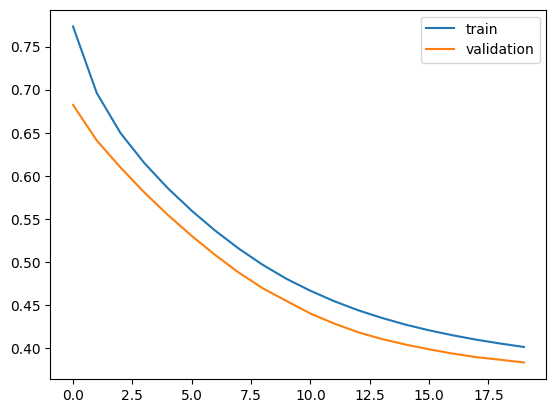

Accuracy


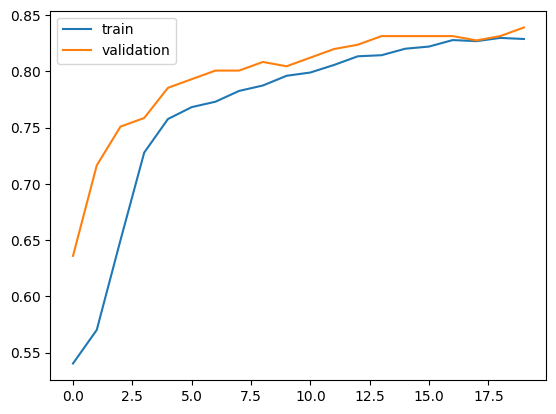

In [27]:
# plot training history
print("loss")
plt.plot(training_phase.history["loss"], label="train")
plt.plot(training_phase.history["val_loss"], label="validation")
plt.legend()
plt.show()
print("Accuracy")
plt.plot(training_phase.history["accuracy"], label="train")
plt.plot(training_phase.history["val_accuracy"], label="validation")
plt.legend()
plt.show()

In [28]:
y_pred = my_model.predict(X_train_pp)
y_pred

41/41 [==============================] - 1s 9ms/step


array([[0.4569565 ],
       [0.7699534 ],
       [0.04928146],
       ...,
       [0.09142774],
       [0.04114624],
       [0.336479  ]], dtype=float32)

In [29]:
# We will look at the predicted Qualities to ensure we have something sensible.
y_predicted = np.round(y_pred).astype(int)
print(y_predicted)

[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]


In [30]:
print(confusion_matrix(y_train, y_predicted))

print("Classification Report:")
print(classification_report(y_train, y_predicted))

[[703  95]
 [124 379]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       798
           1       0.80      0.75      0.78       503

    accuracy                           0.83      1301
   macro avg       0.82      0.82      0.82      1301
weighted avg       0.83      0.83      0.83      1301



In [31]:
# generate a submission file
generateSubmission(
    model=my_model,
    submissionFile="first_NN.csv",
    submissionDescription=DEFAULT_DESCRIPTION
    + "User defined NN trained with all training set",
)

8/8 [==============================] - 0s 7ms/step
NN Submission: User defined NN trained with all training set


### You can consider different models splitting in training and testing

In [32]:
X_train_pp_2, X_test_pp_2, y_train_2, y_test_2 = train_test_split(
    X_train_pp, y_train, train_size=TRAIN_SIZE, random_state=RANDOM_STATE
)

In [33]:
my_model.compile(
    loss="binary_crossentropy",
    optimizer="SGD",
    metrics=["accuracy", tf.keras.metrics.AUC()],
)

training_phase = my_model.fit(
    X_train_pp_2,
    y_train_2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SIZE,
    verbose=1,
)

Epoch 1/20
26/26 [==============================] - 3s 30ms/step - loss: 0.3901 - accuracy: 0.8353 - auc_1: 0.8988 - val_loss: 0.3955 - val_accuracy: 0.8269 - val_auc_1: 0.8907
Epoch 2/20
26/26 [==============================] - 0s 12ms/step - loss: 0.3874 - accuracy: 0.8377 - auc_1: 0.9000 - val_loss: 0.3937 - val_accuracy: 0.8221 - val_auc_1: 0.8908
Epoch 3/20
26/26 [==============================] - 0s 9ms/step - loss: 0.3851 - accuracy: 0.8377 - auc_1: 0.9010 - val_loss: 0.3922 - val_accuracy: 0.8221 - val_auc_1: 0.8917
Epoch 4/20
26/26 [==============================] - 0s 10ms/step - loss: 0.3828 - accuracy: 0.8377 - auc_1: 0.9023 - val_loss: 0.3908 - val_accuracy: 0.8221 - val_auc_1: 0.8926
Epoch 5/20
26/26 [==============================] - 0s 10ms/step - loss: 0.3810 - accuracy: 0.8401 - auc_1: 0.9031 - val_loss: 0.3896 - val_accuracy: 0.8221 - val_auc_1: 0.8930
Epoch 6/20
26/26 [==============================] - 0s 9ms/step - loss: 0.3792 - accuracy: 0.8401 - auc_1: 0.9040 - 

loss


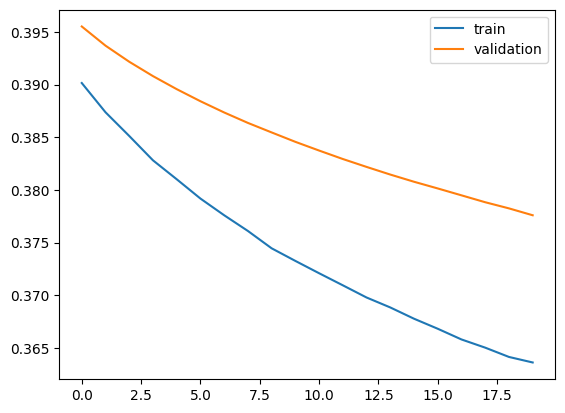

Accuracy


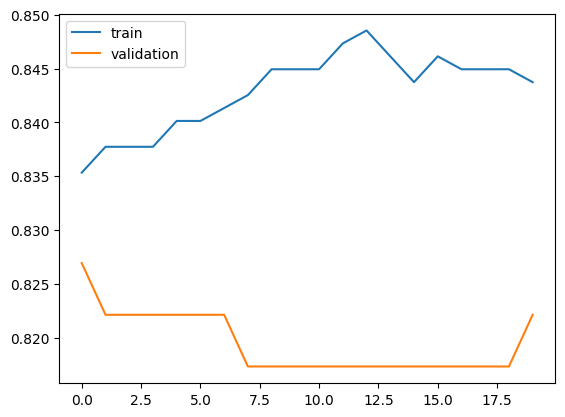

In [34]:
# plot training history
print("loss")
plt.plot(training_phase.history["loss"], label="train")
plt.plot(training_phase.history["val_loss"], label="validation")
plt.legend()
plt.show()
print("Accuracy")
plt.plot(training_phase.history["accuracy"], label="train")
plt.plot(training_phase.history["val_accuracy"], label="validation")
plt.legend()
plt.show()

In [35]:
# Performance on the training set
y_pred_2 = my_model.predict(X_test_pp_2)
y_predicted_2 = np.round(y_pred_2).astype(int)
y_predicted_2 = np.squeeze(y_predicted_2)
print(y_predicted_2.tolist())


9/9 [==============================] - 0s 3ms/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]


In [36]:
print(confusion_matrix(y_test_2, y_predicted_2))

print("Classification Report:")
print(classification_report(y_test_2, y_predicted_2))


[[137  16]
 [ 30  78]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       153
           1       0.83      0.72      0.77       108

    accuracy                           0.82       261
   macro avg       0.83      0.81      0.81       261
weighted avg       0.82      0.82      0.82       261



In [37]:
# Performance on the training set
y_pred_2 = my_model.predict(X_train_pp_2)
y_predicted_2 = np.round(y_pred_2).astype(int)
y_predicted_2 = np.squeeze(y_predicted_2)
#print(y_predicted_2.tolist())
print(confusion_matrix(y_train_2, y_predicted_2))

print("Classification Report:")
print(classification_report(y_train_2, y_predicted_2))

33/33 [==============================] - 0s 7ms/step
[[578  67]
 [ 97 298]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       645
           1       0.82      0.75      0.78       395

    accuracy                           0.84      1040
   macro avg       0.84      0.83      0.83      1040
weighted avg       0.84      0.84      0.84      1040



In [38]:
# generate a submission file
generateSubmission(
    model=my_model,
    submissionFile="second_NN.csv",
    submissionDescription=DEFAULT_DESCRIPTION
    + "User defined NN evaluated with test set",
    preprocessor=preprocessor,
)

8/8 [==============================] - 0s 5ms/step
NN Submission: User defined NN evaluated with test set


Or you can consider different models using cross validation
### Parameter Tuning

In [64]:
from scikeras.wrappers import KerasClassifier
#from tensorflow.contrib.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
keras_model_classifier = KerasClassifier(
    build_fn=build_keras_model,
    input_shape=(13,),
    hidden_units=(6, 4),
    hidden_activation="relu",
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SIZE,
    verbose=1,
)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
22/22 [==============================] - 2s 35ms/step - loss: 0.8514 - accuracy: 0.3781 - auc_2: 0.3199 - val_loss: 0.8912 - val_accuracy: 0.3506 - val_auc_2: 0.3031
Epoch 2/20
22/22 [==============================] - 0s 5ms/step - loss: 0.8022 - accuracy: 0.4040 - auc_2: 0.3482 - val_loss: 0.8334 - val_accuracy: 0.4138 - val_auc_2: 0.3380
Epoch 3/20
22/22 [==============================] - 0s 6ms/step - loss: 0.7687 - accuracy: 0.4343 - auc_2: 0.3743 - val_loss: 0.7926 - val_accuracy: 0.4368 - val_auc_2: 0.3717
Epoch 4/20
22/22 [==============================] - 0s 5ms/step - loss: 0.7451 - accuracy: 0.4704 - auc_2: 0.4016 - val_loss: 0.7640 - val_accuracy: 0.4655 - val_auc_2: 0.3952
Epoch 5/20
22/22 [==============================] - 0s 4ms/step - loss: 0.7283 - accuracy: 0.5007 - auc_2: 0.4292 - val_loss: 0.7425 - val_accuracy: 0.4828 - val_auc_2: 0.4269
Epoch 6/20
22/22 [==============================] - 0s 5ms/step - loss: 0.7156 - accuracy: 0.5238 - auc_2: 0.4526 - val

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


22/22 [==============================] - 2s 32ms/step - loss: 0.7835 - accuracy: 0.3968 - auc_3: 0.3875 - val_loss: 0.7307 - val_accuracy: 0.4828 - val_auc_3: 0.4889
Epoch 2/20
22/22 [==============================] - 0s 10ms/step - loss: 0.7506 - accuracy: 0.4286 - auc_3: 0.4283 - val_loss: 0.6984 - val_accuracy: 0.5402 - val_auc_3: 0.5239
Epoch 3/20
22/22 [==============================] - 0s 11ms/step - loss: 0.7246 - accuracy: 0.4661 - auc_3: 0.4715 - val_loss: 0.6709 - val_accuracy: 0.5862 - val_auc_3: 0.5789
Epoch 4/20
22/22 [==============================] - 0s 8ms/step - loss: 0.7032 - accuracy: 0.5036 - auc_3: 0.5171 - val_loss: 0.6481 - val_accuracy: 0.6149 - val_auc_3: 0.6151
Epoch 5/20
22/22 [==============================] - 0s 11ms/step - loss: 0.6857 - accuracy: 0.5296 - auc_3: 0.5577 - val_loss: 0.6293 - val_accuracy: 0.6207 - val_auc_3: 0.6475
Epoch 6/20
22/22 [==============================] - 0s 8ms/step - loss: 0.6707 - accuracy: 0.5397 - auc_3: 0.5910 - val_loss: 0

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
22/22 [==============================] - 2s 25ms/step - loss: 0.6977 - accuracy: 0.5274 - auc_4: 0.4091 - val_loss: 0.6922 - val_accuracy: 0.6092 - val_auc_4: 0.4436
Epoch 2/20
22/22 [==============================] - 0s 12ms/step - loss: 0.6922 - accuracy: 0.5548 - auc_4: 0.4380 - val_loss: 0.6855 - val_accuracy: 0.6149 - val_auc_4: 0.4861
Epoch 3/20
22/22 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5879 - auc_4: 0.4697 - val_loss: 0.6790 - val_accuracy: 0.6207 - val_auc_4: 0.5196
Epoch 4/20
22/22 [==============================] - 0s 12ms/step - loss: 0.6817 - accuracy: 0.6009 - auc_4: 0.4972 - val_loss: 0.6720 - val_accuracy: 0.6437 - val_auc_4: 0.5491
Epoch 5/20
22/22 [==============================] - 0s 13ms/step - loss: 0.6758 - accuracy: 0.6095 - auc_4: 0.5392 - val_loss: 0.6650 - val_accuracy: 0.6379 - val_auc_4: 0.5878
Epoch 6/20
22/22 [==============================] - 0s 11ms/step - loss: 0.6694 - accuracy: 0.6081 - auc_4: 0.5794 -

<ipython-input-52-73596b889237>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cv_scores)


Text(0.5, 1.0, 'Average score: 0.6563893530294483')

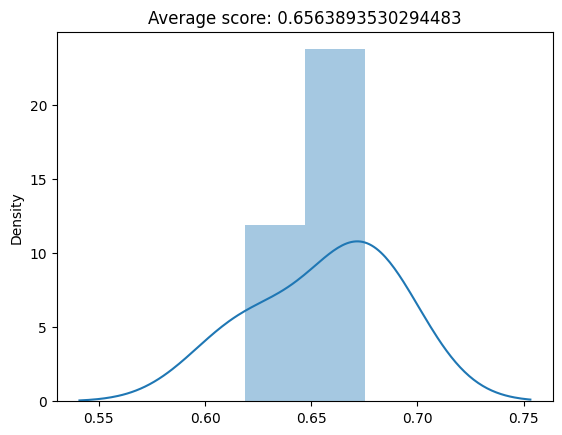

In [52]:
cv_scores = cross_val_score(
    keras_model_classifier, X_train_pp, y_train, cv=3, scoring="accuracy", verbose=1,
)
sns.distplot(cv_scores)
plt.title("Average score: {}".format(np.mean(cv_scores)))

In [53]:
keras_model_classifier.fit(X_train_pp, y_train)
keras_model_classifier.score(X_train_pp, y_train)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
33/33 [==============================] - 2s 13ms/step - loss: 0.8077 - accuracy: 0.5952 - auc_5: 0.4031 - val_loss: 0.7173 - val_accuracy: 0.6667 - val_auc_5: 0.4080
Epoch 2/20
33/33 [==============================] - 0s 7ms/step - loss: 0.7296 - accuracy: 0.5942 - auc_5: 0.4770 - val_loss: 0.6708 - val_accuracy: 0.6705 - val_auc_5: 0.4847
Epoch 3/20
33/33 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5952 - auc_5: 0.5495 - val_loss: 0.6410 - val_accuracy: 0.6667 - val_auc_5: 0.5500
Epoch 4/20
33/33 [==============================] - 0s 4ms/step - loss: 0.6588 - accuracy: 0.5990 - auc_5: 0.6098 - val_loss: 0.6193 - val_accuracy: 0.6820 - val_auc_5: 0.6099
Epoch 5/20
33/33 [==============================] - 0s 4ms/step - loss: 0.6377 - accuracy: 0.6000 - auc_5: 0.6578 - val_loss: 0.6011 - val_accuracy: 0.6782 - val_auc_5: 0.6622
Epoch 6/20
33/33 [==============================] - 0s 4ms/step - loss: 0.6200 - accuracy: 0.6077 - auc_5: 0.6988 - val

0.8170637970791699

In [54]:
generateSubmission(
    model=keras_model_classifier,
    submissionFile="crossval_NN.csv",
    submissionDescription=DEFAULT_DESCRIPTION
    + "User defined NN evaluated with cross validation",
    preprocessor=preprocessor,
    prediction_type="label",
)

8/8 [==============================] - 0s 3ms/step
NN Submission: User defined NN evaluated with cross validation


### Parameter Tuning

In every classification technique, there are some parameters that can be tuned to optimize the classification. Some parameters that can be tuned in the decision tree is max depth (the depth of the tree), max feature (the feature used to classify), criterion, and splitter.

To search to tune parameter is to use Grid Search. Basically, it explores a range of parameters and finds the best combination of parameters. Then repeat the process several times until the best parameters are discovered. We will also use Stratified k-fold cross-validation that will prevent a certain class only split them to the same subset.

In [55]:
# Create the pipeline classifier using keras model as classifier
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", keras_model_classifier),]
)

# Create the parameter grids
parameter_grid = {
    "preprocessor__verbose": [False],
    "classifier__hidden_units": [(13, 8), (6, 4)],
    "classifier__hidden_activation": ["relu", "tanh"],
    "classifier__epochs": [20],
    "classifier__batch_size": [32],
    "classifier__verbose": [0],
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=3)
cross_validation.get_n_splits(X_train_pp, y_train)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=False,  # True,
    refit="accuracy",
)

# You can use X_train without manual preprocessing because preprocessor is built-in the classifier pipeline
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('preproc_numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'resting_bp_s',
                                                                          'max_heart_rate',
                                                                          'cholesterol',
                                                                          'pulse',
                                                                          'oldpeak',
                                                                          'synt']),
                                                                        ('preproc_...
                                        KerasClassifier(batch_size=32, build_fn=<function build_keras_model at 0x79a7e67145e0>, epochs=20, hidden_activation='relu', hidden_units=(6, 4), input_shape=(13,), validation_split=0.2))]),
             param_grid={'classifier__batch_size': [32],
                         'classifier__epochs': [20],
                         'classifier__hidden_activation': ['relu', 'tanh'],
                         'classifier__hidden_units': [(13, 8), (6, 4)],
                         'classifier__verbose': [0],
                         'preprocessor__verbose': [False]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=1)

In [56]:
# grid_search.cv_results_

In [57]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_clf = grid_search.best_estimator_
best_clf

Best score: 0.833982538854773
Best parameters: {'classifier__batch_size': 32, 'classifier__epochs': 20, 'classifier__hidden_activation': 'tanh', 'classifier__hidden_units': (13, 8), 'classifier__verbose': 0, 'preprocessor__verbose': False}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preproc_numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'resting_bp_s',
                                                   'max_heart_rate',
                                                   'cholesterol', 'pulse',
                                                   'oldpeak', 'synt']),
                                                 ('preproc_categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['exercise_angina',
                                                   'fasting_blood_sugar', 'sex',
                                                   'resting_ecg', 'st_slope',
                                                   'chest_pain_type'])])),
                ('classifier',
                 KerasClassifier(batch_size=32, build_fn=<function build_keras_model at 0x79a7e67145e0>, epochs=20, hidden_activation='tanh', hidden_units=(13, 8), input_shape=(13,), validation_split=0.2, verbose=0))])

In [58]:
my_model = best_clf
# my_model.fit(X_train_pp, y_train)
my_model.score(X_train, y_train)

0.8447348193697156

In [59]:
y_pred = my_model.predict(X_train)
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_pred))

print("Classification Report:")
print(classification_report(y_train, y_pred))

Confusion Matrix:
[[697 101]
 [101 402]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       798
           1       0.80      0.80      0.80       503

    accuracy                           0.84      1301
   macro avg       0.84      0.84      0.84      1301
weighted avg       0.84      0.84      0.84      1301



### Submit the final model

In [60]:
# generate a submission file
generateSubmission(
    model=my_model,
    submissionFile="gridcv_NN.csv",
    submissionDescription=DEFAULT_DESCRIPTION
    + "User defined NN evaluated with grid search",
    prediction_type="label",
)

NN Submission: User defined NN evaluated with grid search


Step by step commands...

In addition to your training data, there will be test data. This is frequently stored in a file with the title `test.csv`. This data won't include a column with your target (y), because that is what we'll have to predict and submit.  Here is sample code to do that.

In [61]:
# Read the test data
data = pd.read_csv(DATA_PATH + "test.csv")

Id, X_test = data.Id, data.drop(columns=DROPCOLUMS)

# Use the model to make predictions
y_test_pred = best_clf.predict(X_test)
y_test_pred = np.squeeze(y_test_pred)
print(y_test_pred.tolist())

[1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0]


# Prepare Submission File
We make submissions in CSV files.  Your submissions usually have two columns: an ID column and a prediction column.  The ID field comes from the test data (keeping whatever name the ID field had in that data, which for the housing data is the string 'Id'). The prediction column will use the name of the target field.

We will create a DataFrame with this data, and then use the dataframe's `to_csv` method to write our submission file.  Explicitly include the argument `index=False` to prevent pandas from adding another column in our csv file.

In [62]:
# submission file
my_submission = pd.DataFrame({"Id": Id, "target": y_test_pred})
# you could use any filename. We choose submission here
my_submission.to_csv(OUTPUT_PATH + "submission.csv", index=False)

# Make Submission
Hit the blue **Publish** button at the top of your notebook screen.  It will take some time for your kernel to run.  When it has finished your navigation bar at the top of the screen will have a tab for **Output**.  This only shows up if you have written an output file (like we did in the **Prepare Submission File** step).  

Otherwise, if you have a kaggle API token (https://www.kaggle.com/docs/api#getting-started-installation-&-authentication), you can use the following command (remove the '#'):

In [63]:
#!kaggle competitions submit -c  heart-attack-analysis-and-prediction-21 -f kaggle_submissions/submission.csv -m "Please describe the technique used"


# Last Steps
Click on the Output button.  This will bring you to a screen with an option to **Submit to Competition**.  Hit that and you will see how your model performed.

If you want to go back to improve your model, click the Edit button, which re-opens the kernel.  You'll need to re-run all the cells when you re-open the kernel.

# Conclusion
You've completed Level 1 of Machine Learning.  Congrats.  

If you are ready to keep improving your model (and your skills), start level 2 of [Learn Machine Learning](https://www.kaggle.com/learn/machine-learning).

Level 2 covers more powerful models, techniques to include non-numeric data, and more.  You can make more submissions to the competition and climb up the leaderboard as you go through the course.


